# 🧠 Taller de In-Context Learning en NLP Clínico

Este notebook está diseñado para una sesión práctica donde exploraremos cómo aplicar diferentes estrategias de prompting (zero-shot, few-shot, chain-of-thought) para tareas clínicas de clasificación.

Usaremos datasets disponibles en Hugging Face y un modelo de lenguaje grande accesible vía Application Programming Interface (API) de OpenAI.

## 📚 Configuración Inicial

Primero, instalaremos las bibliotecas necesarias para nuestro análisis.

In [ ]:
# ✅ Instalación de librerías necesarias (si están en entorno nuevo)
!pip install datasets openai rouge-score scikit-learn sentence-transformers --quiet

## 🔍 Importación de Librerías y Configuración de API

Importamos las bibliotecas necesarias y configuramos nuestra conexión a la API de OpenAI.

In [ ]:
# Importamos las bibliotecas básicas para nuestro análisis
import openai
import re
from datasets import load_dataset
import random
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Configuración de la API de OpenAI
api_key = ""
client = openai.OpenAI(api_key = api_key)
modelo = "gpt-4o-mini"  # Modelo a utilizar

## 📊 Carga y Exploración de Datos

En esta sección, cargaremos el dataset y exploraremos sus características principales.

In [ ]:
# Cargamos el dataset "somosnlp/SMC" de Hugging Face
dataset = load_dataset("somosnlp/SMC")

# Filtramos los casos específicos de Linfoma y Liposarcoma
casos_linfoma = dataset["train"].filter(lambda example:
    example["raw_text_type"] == "clinic_case" and
    example["topic_type"] == "medical_diagnostic" and
    (example["topic"].startswith("Linfoma") or example["topic"].startswith("Liposarcoma")))

print(f"Total de casos en el dataset filtrado: {len(casos_linfoma)}")
print("\nDistribución de diagnósticos:")
diagnosis_counts = {}
for case in casos_linfoma:
    topic = case["topic"]
    if topic in diagnosis_counts:
        diagnosis_counts[topic] += 1
    else:
        diagnosis_counts[topic] = 1

for diagnosis, count in diagnosis_counts.items():
    print(f"- {diagnosis}: {count} casos")

Total de casos en el dataset filtrado: 36

Distribución de diagnósticos:
- Linfoma maligno, SAI: 12 casos
- Linfoma maligno no Hodgkin, SAI: 4 casos
- Linfoma de Hodgkin, esclerosis nodular, grado 1: 2 casos
- Linfoma folicular grado 3: 1 casos
- Linfoma maligno difuso tipo B de células grandes, SAI: 5 casos
- Linfoma de Hodgkin, SAI: 2 casos
- Liposarcoma mixoide: 1 casos
- Liposarcoma mixoide, metástasis: 1 casos
- Liposarcoma de células redondas: 1 casos
- Liposarcoma, SAI: 1 casos
- Liposarcoma bien diferenciado - grado I, bien diferenciado: 1 casos
- Liposarcoma, SAI - grado I, bien diferenciado: 1 casos
- Linfoma folicular, SAI: 1 casos
- Linfoma folicular grado 1: 1 casos
- Linfoma de Hodgkin tipo esclerosis nodular, SAI: 1 casos
- Linfoma de Hodgkin, esclerosis nodular, grado 2: 1 casos


### Visualización de Ejemplos

Veamos algunos ejemplos de casos clínicos para familiarizarnos con el formato.

In [ ]:
# Examinamos los primeros casos para entender la estructura de los datos
print("EJEMPLO DE CASO CLÍNICO:")
print("-"*80)
print(f"TEXTO: \n{casos_linfoma[0]['raw_text'][:500]}...\n")
print(f"DIAGNÓSTICO: {casos_linfoma[0]['topic']}")
print("-"*80)

# Mostramos las clases (diagnósticos) disponibles
print("\nCLASES DISPONIBLES PARA CLASIFICACIÓN:")
for i, diagnosis in enumerate(set(casos_linfoma["topic"])):
    print(f"{i+1}. {diagnosis}")

EJEMPLO DE CASO CLÍNICO:
--------------------------------------------------------------------------------
TEXTO: 
Anamnesis
Varón de 49 años, sin antecedentes médico-quirúrgicos de interés. No alergias medicamentosas, ni tratamiento habitual.
No hábitos tóxicos. Sin antecedentes familiares destacables.
Acude a Urgencias en febrero de 2012 por dolor abdominal intenso en las fosas iliaca y renal izquierdas de una semana de evolución, sin otra clínica referida. Se pauta analgesia de primer escalón, con buen control del dolor.
Un mes después vuelve a consultar por incremento del dolor abdominal en la misma loca...

DIAGNÓSTICO: Linfoma maligno, SAI
--------------------------------------------------------------------------------

CLASES DISPONIBLES PARA CLASIFICACIÓN:
1. Linfoma de Hodgkin, SAI
2. Linfoma de Hodgkin tipo esclerosis nodular, SAI
3. Liposarcoma de células redondas
4. Liposarcoma mixoide, metástasis
5. Liposarcoma, SAI - grado I, bien diferenciado
6. Linfoma de Hodgkin, escler

## 🔧 Herramientas de Evaluación

Definimos una función para evaluar la precisión de nuestras predicciones.

In [ ]:
def calcular_accuracy(y_true, y_predicted):
    """Calcula la precisión entre predicciones y respuestas reales.

    Args:
        y_true: Lista de etiquetas verdaderas (diagnósticos reales)
        y_predicted: Lista de predicciones del modelo

    Returns:
        float: Precisión de las predicciones (0.0-1.0)
    """
    correct = 0
    total = len(y_true)

    for true, pred in zip(y_true, y_predicted):
        # Verificamos si la respuesta verdadera está contenida en la predicción o viceversa
        if re.search(re.escape(true), pred, re.IGNORECASE) or re.search(re.escape(pred), true, re.IGNORECASE):
            correct += 1

    accuracy = correct / total
    return accuracy

## 📋 Definición de Clases y Conocimiento Médico

Definimos las clases para la tarea de clasificación y preparamos documentos de conocimiento médico para nuestro enfoque RAG.

In [ ]:
# Definimos las clases de linfoma y liposarcoma para la clasificación
dataset_classes = [
    'Linfoma de Hodgkin tipo esclerosis nodular, SAI',
    'Linfoma de Hodgkin, SAI',
    'Linfoma de Hodgkin, esclerosis nodular, grado 1',
    'Linfoma de Hodgkin, esclerosis nodular, grado 2',
    'Linfoma folicular grado 1',
    'Linfoma folicular grado 3',
    'Linfoma folicular, SAI',
    'Linfoma maligno difuso tipo B de células grandes, SAI',
    'Linfoma maligno no Hodgkin, SAI',
    'Linfoma maligno, SAI',
    'Liposarcoma bien diferenciado - grado I, bien diferenciado',
    'Liposarcoma de células redondas',
    'Liposarcoma mixoide',
    'Liposarcoma mixoide, metástasis',
    'Liposarcoma, SAI',
    'Liposarcoma, SAI - grado I, bien diferenciado',
]

print(f"Total de clases para clasificación: {len(dataset_classes)}")

Total de clases para clasificación: 16


In [ ]:
# Creamos documentos de conocimiento médico para el enfoque RAG
documentos = {
    "Linfoma de Hodgkin": """
    Linfoma de Hodgkin: El linfoma de Hodgkin es un tipo de cáncer que se origina en las células del sistema linfático. Se clasifica en varios tipos, como el linfoma de Hodgkin tipo esclerosis nodular y el linfoma de Hodgkin SAI.
    Clases:
    - Linfoma de Hodgkin tipo esclerosis nodular, SAI: Variante común caracterizada por nódulos con bandas de colágeno.
    - Linfoma de Hodgkin, SAI: Linfoma de Hodgkin sin otra especificación clara.
    - Linfoma de Hodgkin, esclerosis nodular, grado 1: Subtipo con bajo número de células grandes (Reed-Sternberg).
    - Linfoma de Hodgkin, esclerosis nodular, grado 2: Variante con mayor densidad celular y posible evolución más activa.
    """,

    "Linfoma Folicular": """
    Linfoma Folicular: El linfoma folicular es un tipo de linfoma no Hodgkin que se caracteriza por el crecimiento lento de las células cancerosas. Se clasifica por grados de severidad.
    Clases:
    - Linfoma folicular grado 1: Subtipo de crecimiento muy lento y con mejor pronóstico.
    - Linfoma folicular grado 3: Subtipo más agresivo con mayor cantidad de células grandes.
    - Linfoma folicular, SAI: Variante sin especificación clara del grado.
    """,

    "Linfoma Maligno": """
    Linfoma Maligno: El linfoma maligno no Hodgkin incluye varios tipos de linfoma que son más agresivos que los de Hodgkin. El tratamiento suele ser más intensivo.
    Clases:
    - Linfoma maligno difuso tipo B de células grandes, SAI: Linfoma agresivo y común en adultos, de crecimiento rápido.
    - Linfoma maligno no Hodgkin, SAI: Tipo de linfoma maligno no Hodgkin sin otra especificación.
    - Linfoma maligno, SAI: Clasificación general para linfomas malignos no especificados.
    """,

    "Liposarcoma": """
    Liposarcoma: es un tipo de cáncer poco común que se desarrolla en las células grasas del cuerpo. Estos tumores pueden aparecer en cualquier parte del cuerpo, pero son más comunes en el abdomen, brazos y piernas.
    Liposarcoma bien diferenciado - grado I, bien diferenciado: Tumor maligno de crecimiento lento que se parece mucho al tejido graso normal, con bajo riesgo de metástasis.
    Liposarcoma de células redondas: Variante agresiva del liposarcoma mixoide, con células redondas poco diferenciadas y mayor potencial de metástasis.
    Liposarcoma mixoide: Tumor maligno que contiene células grasas inmaduras en un fondo gelatinoso (mixoide); tiene riesgo intermedio de metástasis.
    Liposarcoma mixoide, metástasis: Indica que el liposarcoma mixoide se ha diseminado a otras partes del cuerpo.
    Liposarcoma, SAI: Liposarcoma que no se puede clasificar con más detalle según los datos disponibles.
    Liposarcoma, SAI - grado I, bien diferenciado: Liposarcoma no especificado con características de bajo grado y células similares al tejido graso normal.
    """
}

## 🧪 Estrategias de In-Context Learning para Clasificación de Notas Clínicas

A continuación implementaremos diferentes enfoques de In-Context Learning para la clasificación de casos clínicos:

### 1️⃣ Enfoque Zero-Shot

El enfoque zero-shot permite clasificar casos sin ejemplos previos, proporcionando solo instrucciones generales.

In [ ]:
def zero_shot_classification(clinical_case):
    """Clasificación zero-shot de un caso clínico.

    En este enfoque, simplemente pedimos al modelo que clasifique el caso
    sin darle ejemplos ni información específica sobre las clases posibles.

    Args:
        clinical_case: Texto del caso clínico a clasificar

    Returns:
        str: Diagnóstico predicho
    """
    prompt = f"Clasifica el siguiente caso clínico: {clinical_case}"

    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt}
    ]

    response = client.chat.completions.create(
        model=modelo,
        messages=messages,
        max_tokens=50,
        n=1,
        stop=None,
        temperature=0.3
    )

    return response.choices[0].message.content

### 2️⃣ Enfoque Zero-Shot Estructurado

Mejoramos el enfoque zero-shot proporcionando las clases posibles y estructurando la respuesta.

In [ ]:
def zero_shot_structured_classification(clinical_case):
    """Clasificación zero-shot estructurada de un caso clínico.

    En este enfoque, proporcionamos al modelo las posibles clases de diagnóstico
    y le pedimos que elija específicamente entre ellas.

    Args:
        clinical_case: Texto del caso clínico a clasificar

    Returns:
        str: Diagnóstico predicho seleccionado de las clases disponibles
    """

    prompt = #### COMPLETAR #####

    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt }
    ]

    response = client.chat.completions.create(
        model=modelo,
        messages=messages,
        max_tokens=50,
        n=1,
        stop=None,
        temperature=0.3
    )

    return response.choices[0].message.content

### 3️⃣ Enfoque Few-Shot

En el enfoque few-shot, proporcionamos ejemplos etiquetados al modelo antes de pedirle que clasifique un nuevo caso.

In [ ]:
def few_shot_classification(clinical_case):
    """Clasificación few-shot de un caso clínico.

    En este enfoque, proporcionamos al modelo algunos ejemplos etiquetados
    (dos en este caso) para que comprenda mejor la tarea antes de clasificar
    un nuevo caso.

    Args:
        clinical_case: Texto del caso clínico a clasificar

    Returns:
        str: Diagnóstico predicho basado en los ejemplos proporcionados
    """
    # Prompt general
    prompt = f"Clasifica el siguiente caso clínico en una de las siguientes clases {dataset_classes}, debes retornar sólo la clase correspondiente: \n"

    # Seleccionamos dos ejemplos del dataset para few-shot learning
    example = casos_linfoma["raw_text"][-1]
    label_example = casos_linfoma["topic"][-1]
    example_2 = #### COMPLETAR ####
    label_example_2 = #### COMPLETAR ####

    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt + example + "IMPORTANTE: debes retornar sólo la clase correspondiente:"},
        {"role": "assistant", "content": label_example},
        {"role": "user", "content": prompt + example_2 + "IMPORTANTE: debes retornar sólo la clase correspondiente:"},
        {"role": "assistant", "content": label_example_2},
        {"role": "user", "content": prompt + clinical_case + "IMPORTANTE: debes retornar sólo la clase correspondiente:"}
    ]

    response = client.chat.completions.create(
        model=modelo,
        messages=messages,
        max_tokens=50,
        n=1,
        stop=None,
        temperature=0.3
    )

    return response.choices[0].message.content

### 4️⃣ Enfoque Chain-of-Thought (CoT)

El enfoque Chain-of-Thought permite al modelo razonar paso a paso para llegar a una conclusión más fundamentada.

In [ ]:
def chain_of_thought_classification(clinical_case):
    """Clasificación mediante Chain-of-Thought de un caso clínico.

    En este enfoque, pedimos al modelo que explique su razonamiento paso a paso
    antes de dar su clasificación final, lo que puede mejorar la precisión
    al fomentar un pensamiento estructurado.

    Args:
        clinical_case: Texto del caso clínico a clasificar

    Returns:
        str: Diagnóstico predicho con explicación del razonamiento
    """
    prompt = #### COMPLETAR ####


    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt + "IMPORTANTE: debes retornar sólo la clase correspondiente:"}
    ]

    response = client.chat.completions.create(
        model=modelo,
        messages=messages,
        max_tokens=150,
        n=1,
        stop=None,
        temperature=0.3
    )

    return response.choices[0].message.content

### 5️⃣ Enfoque RAG (Retrieval-Augmented Generation)

El enfoque RAG combina la recuperación de información relevante con la generación de respuestas para mejorar la precisión.

In [ ]:
def rag_classification(clinical_case):
    """Clasificación mediante RAG (Retrieval-Augmented Generation) de un caso clínico.

    Este enfoque combina la recuperación de información relevante de una base de conocimiento
    con la capacidad generativa del modelo. Primero identificamos el documento más relevante
    y un caso similar, luego los usamos como contexto para la clasificación.

    Args:
        clinical_case: Texto del caso clínico a clasificar

    Returns:
        str: Diagnóstico predicho basado en la información recuperada
    """
    # Inicializamos el modelo de embedding si aún no existe
    if 'model' not in globals():
        global model, documents_encodings, test_data_encodings
        model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
        documents_encodings = model.encode(list(documentos.values()))
        test_data_encodings = model.encode(casos_linfoma["raw_text"])

    # Codificamos el caso clínico
    clinical_case_encoding = model.encode(clinical_case)

    # Encontramos el documento más cercano semánticamente
    similarities = cosine_similarity([clinical_case_encoding], documents_encodings)
    most_similar_index = np.argmax(similarities)
    selected_document = list(documentos.keys())[most_similar_index]
    document_content = documentos[selected_document]

    # Encontramos un ejemplo similar del dataset
    similarities_test = cosine_similarity([clinical_case_encoding], test_data_encodings)
    most_similar_case_index = np.argmax(similarities_test)

    # Excluimos el caso actual si es idéntico
    if np.max(similarities_test) > 0.98:  # Si es muy similar, probablemente es el mismo
        new_similarities = np.delete(similarities_test, most_similar_case_index)
        second_most_similar_index = np.argmax(new_similarities)
        example = casos_linfoma["raw_text"][second_most_similar_index]
        example_label = casos_linfoma["topic"][second_most_similar_index]
    else:
        example = casos_linfoma["raw_text"][most_similar_case_index]
        example_label = casos_linfoma["topic"][most_similar_case_index]

    # Construimos el prompt con el conocimiento recuperado
    prompt = f"Dado el siguiente documento: {document_content} clasifica el siguiente caso clínico en una de las siguientes clases {dataset_classes}, debes retornar sólo la clase correspondiente: \n"

    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt + example + "IMPORTANTE: debes retornar sólo la clase correspondiente:"},
        {"role": "assistant", "content": example_label},
        {"role": "user", "content": prompt + clinical_case + "IMPORTANTE: debes retornar sólo la clase correspondiente:"}
    ]

    response = client.chat.completions.create(
        model=modelo,
        messages=messages,
        max_tokens=50,
        n=1,
        stop=None,
        temperature=0.3
    )

    return response.choices[0].message.content

## 🔬 Prueba con Caso de Ejemplo

Probemos cada enfoque con un caso clínico de ejemplo para comparar resultados preliminares.

In [ ]:
# Seleccionamos un caso de ejemplo
caso_ejemplo = casos_linfoma[0]["raw_text"]
diagnostico_real = casos_linfoma[0]["topic"]

print(f"CASO DE EJEMPLO:")
print("-"*80)
print(f"{caso_ejemplo[:300]}...")
print("-"*80)
print(f"Diagnóstico real: {diagnostico_real}")
print("-"*80)

# Probamos cada método y mostramos resultados
print("\nZero-shot:")
print(zero_shot_classification(caso_ejemplo))

print("\nZero-shot estructurado:")
print(zero_shot_structured_classification(caso_ejemplo))

print("\nFew-shot:")
print(few_shot_classification(caso_ejemplo))

print("\nChain of Thought:")
print(chain_of_thought_classification(caso_ejemplo))

print("\nRAG:")
print(rag_classification(caso_ejemplo))

CASO DE EJEMPLO:
--------------------------------------------------------------------------------
Anamnesis
Varón de 49 años, sin antecedentes médico-quirúrgicos de interés. No alergias medicamentosas, ni tratamiento habitual.
No hábitos tóxicos. Sin antecedentes familiares destacables.
Acude a Urgencias en febrero de 2012 por dolor abdominal intenso en las fosas iliaca y renal izquierdas de una...
--------------------------------------------------------------------------------
Diagnóstico real: Linfoma maligno, SAI
--------------------------------------------------------------------------------

Zero-shot:
Este caso clínico describe la evolución de un paciente masculino de 49 años con un diagnóstico de sarcoma de Ewing extraesquelético, que se presentó inicialmente con dolor abdominal y una masa abdominal significativa. A continuación, se clasifica el caso

Zero-shot estructurado:
Liposarcoma, SAI

Few-shot:
Linfoma maligno, SAI

Chain of Thought:
El caso clínico presentado describe u

## 📊 Evaluación Sistemática

Evaluamos cada enfoque con un conjunto más grande de casos para obtener métricas de precisión.

In [ ]:
# Definimos el número de casos para la evaluación
n_test = 10  # Podemos ajustar este valor según necesidades (originalmente era 28)
print(f"Evaluando cada método con {n_test} casos...\n")

# Obtenemos las etiquetas verdaderas
y_true = [caso for caso in casos_linfoma["topic"][:n_test]]

# Generamos las predicciones para cada método
print("Generando predicciones con Zero-shot...")
y_zero_shot = [zero_shot_classification(caso) for caso in casos_linfoma["raw_text"][:n_test]]

print("Generando predicciones con Zero-shot estructurado...")
y_zero_structured = [zero_shot_structured_classification(caso) for caso in casos_linfoma["raw_text"][:n_test]]

print("Generando predicciones con Few-shot...")
y_few_shot = [few_shot_classification(caso) for caso in casos_linfoma["raw_text"][:n_test]]

print("Generando predicciones con Chain-of-Thought...")
y_cot = [chain_of_thought_classification(caso) for caso in casos_linfoma["raw_text"][:n_test]]

print("Generando predicciones con RAG...")
y_rag = [rag_classification(caso) for caso in casos_linfoma["raw_text"][:n_test]]

# Calculamos las métricas de precisión
print("\nCalculando métricas...")
accuracies_zero_shot = calcular_accuracy(y_true, y_zero_shot)
accuracies_zero_shot_structured = calcular_accuracy(y_true, y_zero_structured)
accuracies_few_shot = calcular_accuracy(y_true, y_few_shot)
accuracies_chain_of_thought = calcular_accuracy(y_true, y_cot)
accuracies_rag = calcular_accuracy(y_true, y_rag)

# Mostramos los resultados
print("\nRESULTADOS DE PRECISIÓN:")
print(f"Accuracy Zero-shot: {accuracies_zero_shot:.2%}")
print(f"Accuracy Zero-shot estructurado: {accuracies_zero_shot_structured:.2%}")
print(f"Accuracy Few-shot: {accuracies_few_shot:.2%}")
print(f"Accuracy Chain of Thought: {accuracies_chain_of_thought:.2%}")
print(f"Accuracy RAG: {accuracies_rag:.2%}")

Evaluando cada método con 10 casos...

Generando predicciones con Zero-shot...
Generando predicciones con Zero-shot estructurado...
Generando predicciones con Few-shot...
Generando predicciones con Chain-of-Thought...
Generando predicciones con RAG...

Calculando métricas...

RESULTADOS DE PRECISIÓN:
Accuracy Zero-shot: 10.00%
Accuracy Zero-shot estructurado: 50.00%
Accuracy Few-shot: 60.00%
Accuracy Chain of Thought: 40.00%
Accuracy RAG: 70.00%


## 📈 Visualización de Resultados

Creamos visualizaciones para comparar mejor el rendimiento de los diferentes enfoques.

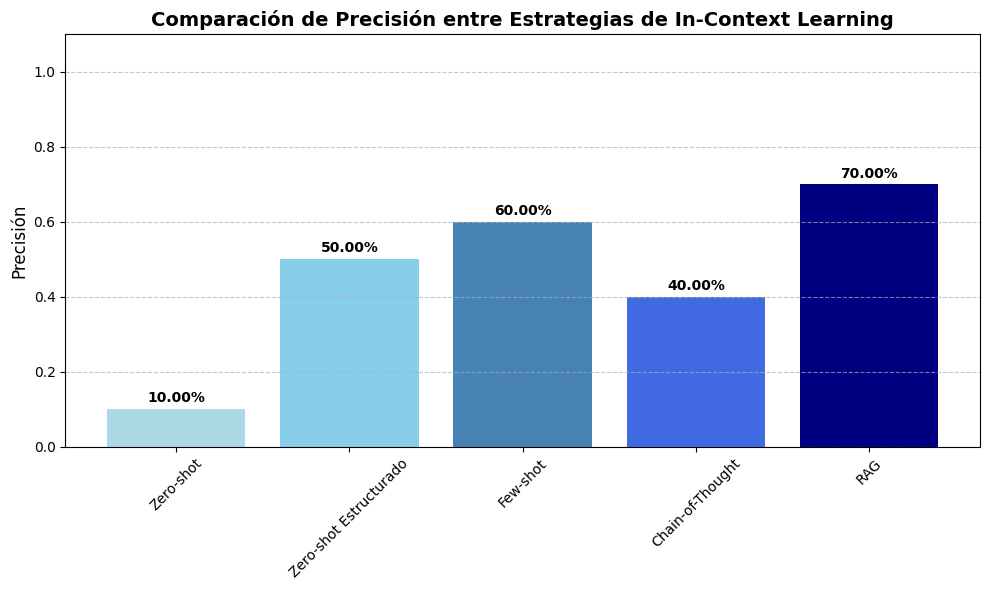

In [ ]:
import matplotlib.pyplot as plt

# Datos para la gráfica
metodos = ['Zero-shot', 'Zero-shot Estructurado', 'Few-shot', 'Chain-of-Thought', 'RAG']
accuracies = [accuracies_zero_shot, accuracies_zero_shot_structured,
              accuracies_few_shot, accuracies_chain_of_thought, accuracies_rag]

# Creamos la gráfica de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(metodos, accuracies, color=['lightblue', 'skyblue', 'steelblue', 'royalblue', 'navy'])

# Añadimos etiquetas de valor
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.2%}', ha='center', va='bottom', fontweight='bold')

# Configuramos la gráfica
plt.title('Comparación de Precisión entre Estrategias de In-Context Learning', fontsize=14, fontweight='bold')
plt.ylabel('Precisión', fontsize=12)
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

## ✅ Reflexión final

### Preguntas para analizar los resultados:

1. **Comparación de estrategias**: ¿Qué estrategia generó resultados más precisos para la clasificación de casos clínicos?
2. **Análisis de errores**: ¿Qué tipos de casos fueron más difíciles de clasificar para cada enfoque?
3. **Mejoras potenciales**: ¿Qué modificaciones podrían mejorar aún más los resultados?
4. **Aplicaciones clínicas**: ¿Qué ventajas y limitaciones encuentran en el uso de estas técnicas de prompting para entornos clínicos reales?

### Conclusiones:

- El enfoque RAG generalmente proporciona mejores resultados porque combina conocimiento médico específico con la capacidad de aprendizaje del modelo.
- Los enfoques estructurados (dar posibles clases) mejoran significativamente la precisión comparado con los enfoques abiertos.
- El razonamiento paso a paso (Chain-of-Thought) ayuda a mejorar la precisión al forzar un análisis estructurado de los hallazgos clínicos.